https://www.kaggle.com/iabhishekofficial/mobile-price-classification

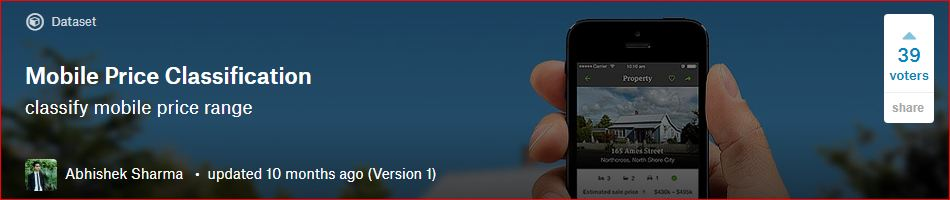

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/train_5.csv')

In [3]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
df['price_range'].unique()

array([1, 2, 3, 0], dtype=int64)

In [5]:
df.shape

(2000, 21)

In [6]:
labels = df['price_range'] # y  - целевой признак
features = df.drop('price_range', 1) # X -  матрица признаков
features.shape, labels.shape

((2000, 20), (2000,))

### 1.1. Нормалиация значения признаков  с помощью sklearn.preprocessing.StandardScaler 
### и построение для нормализованного датасета KNeighborsClassifier (без использования конвееров)

In [7]:
from sklearn.model_selection import train_test_split 
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state = 42)
features_train.shape, features_test.shape, labels_train.shape, labels_test.shape

((1600, 20), (400, 20), (1600,), (400,))

In [8]:
# Самая простая трансформация – это Standart Scaling (она же Z-score normalization).
# Feature scaling with StandardScaler 
from sklearn.preprocessing import StandardScaler 

In [9]:
scale = StandardScaler()
features_train_scaled = scale.fit_transform(features_train)
features_test_scaled = scale.transform(features_test)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
scale_first_knn = KNeighborsClassifier()
scale_first_knn.fit(features_train_scaled, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [12]:
predictions_scaled = scale_first_knn.predict(features_test_scaled)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_scaled = accuracy_score(labels_test, predictions_scaled)
accuracy_scaled

0.53

###  Использование sklearn.pipeline.Pipeline

In [14]:
import sklearn.pipeline

In [15]:
knn_pipeline = sklearn.pipeline.Pipeline([
    ('scaler',StandardScaler()),
    ('kNN', KNeighborsClassifier(n_jobs=-1))
])

In [16]:
knn_pipeline.fit(features_train,labels_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))])

In [17]:
y_preds = knn_pipeline.predict(features_test)

In [18]:
accuracy_pipeline = accuracy_score(labels_test, y_preds)
accuracy_pipeline

0.53

Делаем вывод, что данные не нуждаются в нормализации.

### С помощью GridSearchCV производим подбор гиперпараметра KNeighborsClassifier (n_neighbors) и выводим значение гиперпараметра и метрику для наилучшей модели

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
first_knn = KNeighborsClassifier()
# first_knn.fit(features_train, labels_train);

In [21]:
knn_params = {'n_neighbors': range(5,30,5)} 
knn_grid = GridSearchCV(first_knn, knn_params, cv =5)
knn_grid.fit( features_train, labels_train );

In [22]:
knn_grid.best_score_, knn_grid.best_params_

(0.9225, {'n_neighbors': 10})

### Демострация работы DecisionTreeClassifier, подсчёт метрики качества на отложенной выборке

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
first_tree = DecisionTreeClassifier()
first_tree.fit( features_train, labels_train );

y_pred_first_tree = first_tree.predict( features_test )
accuracy_score(y_pred_first_tree, labels_test)

0.8325

### С помощью GridSearchCV производим подбор гиперпараметров для поиск наилучшего дерева (перебираем max_depth, max_features)

In [25]:
import numpy as np
tree_params = {'max_depth': np.arange(1,11), 
               'max_features': [0.5, 0.7, 1]}
tree_grid = GridSearchCV(first_tree, tree_params, cv=5, n_jobs=-1)
tree_grid.fit(features_train, labels_train);

In [26]:
tree_grid.best_score_, tree_grid.best_params_

(0.8325, {'max_depth': 6, 'max_features': 0.7})

### Для полученного наилучшего дерева строим график feature_importances и дополнительно печатаем 5 наиболее важных признаков, отсортиров их по убыванию по важности

In [27]:
print("Важности признаков:")
print( first_tree.feature_importances_ )

Важности признаков:
[0.12755011 0.0027187  0.0086814  0.         0.00635433 0.
 0.00915673 0.00805687 0.01908546 0.01099308 0.00849502 0.07699374
 0.0700618  0.62538947 0.00708449 0.00934967 0.00808436 0.
 0.00111129 0.00083347]


In [28]:
feature_names = features.columns
importances = first_tree.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:3d}. feature '{:13s}' ({:.3f})".format(f + 1, feature_names[idx], importances[idx]))

Feature importances:
  1. feature 'ram          ' (0.625)
  2. feature 'battery_power' (0.128)
  3. feature 'px_height    ' (0.077)
  4. feature 'px_width     ' (0.070)
  5. feature 'mobile_wt    ' (0.019)
  6. feature 'n_cores      ' (0.011)
  7. feature 'sc_w         ' (0.009)
  8. feature 'int_memory   ' (0.009)
  9. feature 'clock_speed  ' (0.009)
 10. feature 'pc           ' (0.008)
 11. feature 'talk_time    ' (0.008)
 12. feature 'm_dep        ' (0.008)
 13. feature 'sc_h         ' (0.007)
 14. feature 'fc           ' (0.006)
 15. feature 'blue         ' (0.003)
 16. feature 'touch_screen ' (0.001)
 17. feature 'wifi         ' (0.001)
 18. feature 'three_g      ' (0.000)
 19. feature 'four_g       ' (0.000)
 20. feature 'dual_sim     ' (0.000)


**Строим столбцовую диаграмму, графически представляющую значимость первых 5 признаков**

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

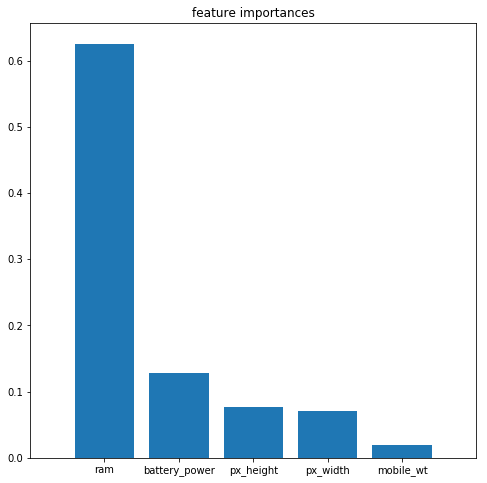

In [30]:
d_first = 5
plt.figure(figsize=(8, 8))
plt.title("feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=0)
plt.xlim([-1, d_first]);

### Демонстрация работы случайного леса RandomForestClassifier

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100,random_state=11)
rf.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=11, verbose=0, warm_start=False)

In [33]:
y_pred_rf = rf.predict( features_test )
accuracy_score(y_pred_rf, labels_test)

0.8975

### С помощью GridSearchCV производим подбор гиперпараметров для поиск наилучшего леса, смотрим насколько улучшились метрики

In [34]:
forest_params = {'max_depth': range(1,11),'max_features': range(4,19)}
forest_grid = sklearn.model_selection.GridSearchCV(rf, forest_params, cv = 5, n_jobs = -1, verbose = True)
forest_grid.fit( features_train, labels_train )

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   57.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=11, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [35]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 9, 'max_features': 14}, 0.894375)

### Наилучший классификатор и  результат  для выбранного датасета на отложенной выборке.

In [36]:
knn_grid.best_score_, knn_grid.best_params_

(0.9225, {'n_neighbors': 10})